# Early Model Testing

In [4]:
%matplotlib inline
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import numpy as np
import seaborn as sns
import os
import time
from sklearn.ensemble import RandomForestRegressor

### Load dataset

In [5]:
input_file_name = "lotOfFeatures.csv"
input_file_path = os.path.join(os.path.join(os.getcwd(), "data"), input_file_name)

original_data = pd.read_csv(input_file_path, index_col=0, parse_dates=True)
originalSize = original_data.shape[1]
original_data.head()
original_data.shape

(139678, 535)

## Excluding Testing Set

Spliting the dataset into three parts: training, testing and evaluation (last 10 percent).

In [6]:
start_time = '2012-02-01 00:00:00'
#start_time = '2014-02-01 00:00:00'
splitting_point = int(0.9 * original_data.shape[0])
splitting_time = original_data.iloc[[splitting_point]].index.to_pydatetime()[0]
#data = original_data[:splitting_time]
data = original_data[start_time:]

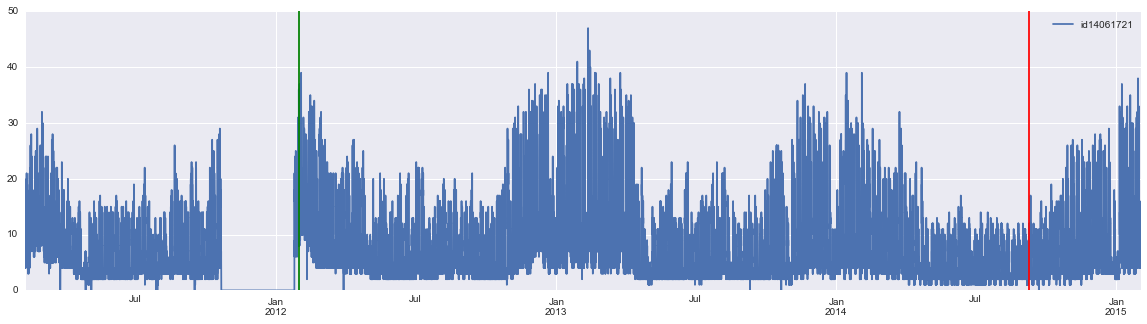

In [7]:
f = original_data[["id14061721"]].plot(figsize=(20,5)) 
original_data.iloc(splitting_point)
f.axvline(start_time, color='g')
f.axvline(splitting_time, color='r')

## Feature Importances

Mean importances of all sensors

In [8]:
autoregressive_cols = ['measurement', 'shifted_measurement_1d', 'shifted_measurement_2d', 'shifted_measurement_1w', 
                       'measurement_roll_mean_1h', 'measurement_roll_mean_6h', 'measurement_roll_mean_d', 
                       'measurement_roll_mean_w', 'measurement_roll_mean_m', 'measurement_roll_min2_d',
                       'measurement_roll_min2_w', 'measurement_roll_max2_d', 'measurement_roll_max2_w',
                       'measurement_roll_var_6h', 'measurement_roll_var_d', 'measurement_roll_var_w']

wetaher_current_cols =  ['p', 't2m_termin', 'rh_termin', 'padavine', 'veter_hitrost', 'veter_vek_smer', 'energija_gl',
 'energija_di', 'p_roll_mean_1h', 'p_roll_mean_6h', 'p_roll_mean_d', 'p_roll_mean_w', 'p_roll_mean_m', 'p_roll_var_1h',
 'p_roll_var_d', 't2m_termin_roll_mean_1h', 't2m_termin_roll_mean_6h', 't2m_termin_roll_mean_d', 't2m_termin_roll_mean_w',
 't2m_termin_roll_mean_m', 't2m_termin_roll_min2_d', 't2m_termin_roll_min2_w', 't2m_termin_roll_max2_d',
 't2m_termin_roll_max2_w', 't2m_termin_roll_var_1h', 't2m_termin_roll_var_d', 'rh_termin_roll_mean_1h',
 'rh_termin_roll_mean_6h', 'rh_termin_roll_mean_d', 'rh_termin_roll_mean_w', 'rh_termin_roll_mean_m',
 'rh_termin_roll_min2_d', 'rh_termin_roll_min2_w', 'rh_termin_roll_max2_d', 'rh_termin_roll_max2_w',
 'rh_termin_roll_var_1h', 'rh_termin_roll_var_d', 'energija_gl_roll_mean_1h', 'energija_gl_roll_mean_6h',
 'energija_gl_roll_mean_d', 'energija_gl_roll_mean_w', 'energija_gl_roll_mean_m', 'energija_gl_roll_var_1h',
 'energija_gl_roll_var_d']

weather_forecasted_cols =  ['shifted_p', 'shifted_t2m_termin', 'shifted_rh_termin', 'shifted_padavine', 
                            'shifted_veter_hitrost', 'shifted_veter_vek_smer', 'shifted_energija_gl']

date_time_cols =  ['shifted_HourOfDay', 'shifted_DayOfWeek', 'shifted_Month', 'shifted_Weekday', 'shifted_Weekend', 
                   'shifted_Holiday', 'shifted_DayBeforeHoliday', 'shifted_DayAfterHodliay', 'shifted_BusinessDay', 
                   'shifted_BusinessDay_sum', 'shifted_Holiday_sum']

feature_importances = pd.DataFrame(columns=pd.MultiIndex.from_arrays([[],[]], names=['sensor', 'horizon']))
feature_importances.index.name = "Feature"

In [9]:
sensors_list = list(data)[:30] # Sensor ids (30)

for sensor_name in sensors_list:
    print "Working with sensor: {}".format(sensor_name)
    
    # Create dataframe for specific sensor
    sensor_cols_to_drop = [col for col in list(data) if col.startswith('id') and not col.startswith(sensor_name)]
    sensor_data_cols = [col for col in list(data) if col not in sensor_cols_to_drop]
    sensor_data = data[sensor_data_cols]
    
    # Replace 'sensor id' column names with 'measurement'
    sensor_data.rename(columns=lambda col: col.replace(sensor_name, 'measurement') if sensor_name in col else col, inplace=True)
    
    # Prepare columns to shift
    columnsToShift = list(sensor_data)
    shiftedColumns = ["shifted_" + col for col in columnsToShift]
    
    # Prepare datasets
    #measurements_cols = [col for col in list(sensor_data) if col.startswith('measurement')]    
    all_cols = autoregressive_cols + wetaher_current_cols + weather_forecasted_cols + date_time_cols 

    for horizon in range (1,25):
        print "Horizon: {}h".format(horizon)
        
        sensor_data[shiftedColumns] = sensor_data[columnsToShift].shift(-1 * horizon, freq='H')
        sensor_data.dropna(inplace=True)

        training_data = sensor_data[:splitting_time]
        testing_data = sensor_data[splitting_time:]

        model = RandomForestRegressor(n_estimators = 100, min_samples_leaf = 10, n_jobs=32)

        X_train = training_data[all_cols].values
        y_train = training_data[["shifted_measurement"]].values.ravel()

        X_test = testing_data[all_cols].values
        y_test = testing_data[["shifted_measurement"]].values.ravel()

        start = time.time() # Start measuring time
        model.fit(X_train,y_train)
        runtime = time.time() - start # Calculate runtime

        feature_importances.loc[:,(sensor_name, horizon)] = model.feature_importances_

feature_importances.index = all_cols # Replaces index names
#feature_importances

Working with sensor: id14061671
Horizon: 1h

D:\Users\bkazic\Envs\py27_64bit\lib\site-packages\pandas\core\frame.py:2524: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)
D:\Users\bkazic\Envs\py27_64bit\lib\site-packages\pandas\core\frame.py:2148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]



Horizon: 2h
Horizon: 3h
Horizon: 4h
Horizon: 5h
Horizon: 6h
Horizon: 7h
Horizon: 8h
Horizon: 9h
Horizon: 10h
Horizon: 11h
Horizon: 12h
Horizon: 13h
Horizon: 14h
Horizon: 15h
Horizon: 16h
Horizon: 17h
Horizon: 18h
Horizon: 19h
Horizon: 20h
Horizon: 21h
Horizon: 22h
Horizon: 23h
Horizon: 24h
Working with sensor: id14061684
Horizon: 1h
Horizon: 2h
Horizon: 3h
Horizon: 4h
Horizon: 5h
Horizon: 6h
Horizon: 7h
Horizon: 8h
Horizon: 9h
Horizon: 10h
Horizon: 11h
Horizon: 12h
Horizon: 13h
Horizon: 14h
Horizon: 15h
Horizon: 16h
Horizon: 17h
Horizon: 18h
Horizon: 19h
Horizon: 20h
Horizon: 21h
Horizon: 22h
Horizon: 23h
Horizon: 24h
Working with sensor: id14061709
Horizon: 1h
Horizon: 2h
Horizon: 3h
Horizon: 4h
Horizon: 5h
Horizon: 6h
Horizon: 7h
Horizon: 8h
Horizon: 9h
Horizon: 10h
Horizon: 11h
Horizon: 12h
Horizon: 13h
Horizon: 14h
Horizon: 15h
Horizon: 16h
Horizon: 17h
Horizon: 18h
Horizon: 19h
Horizon: 20h
Horizon: 21h
Horizon: 22h
Horizon: 23h
Horizon: 24h
Working with sensor: id14061716
Horizo

D:\Users\bkazic\Envs\py27_64bit\lib\site-packages\IPython\kernel\__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [10]:
output_file_name = "featureImportanceResultsAllNew.csv"
output_file_path = os.path.join(os.path.join(os.getcwd(), "data"), output_file_name)

feature_importances.to_csv(output_file_path)

Compute means of all sensors

In [11]:
feature_importances_all = feature_importances.groupby(level='horizon',axis=1).mean()
feature_importances_all

horizon,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
measurement,0.606680,0.184148,0.063959,0.018727,0.007431,0.004422,0.003464,0.003648,0.002131,0.002749,...,0.004381,0.001383,0.001166,0.001198,0.001383,0.002003,0.002109,0.002408,0.002269,0.027257
shifted_measurement_1d,0.026476,0.061081,0.076868,0.085147,0.087946,0.088310,0.089914,0.091967,0.092278,0.092898,...,0.098006,0.097015,0.097646,0.095507,0.085684,0.061714,0.048305,0.066870,0.060982,0.027680
shifted_measurement_2d,0.003720,0.006125,0.007120,0.007704,0.008240,0.008556,0.008560,0.008441,0.008881,0.008504,...,0.009038,0.008663,0.008689,0.008699,0.008164,0.008010,0.007396,0.007561,0.007492,0.007462
shifted_measurement_1w,0.083884,0.396689,0.419818,0.443881,0.445707,0.446498,0.447161,0.447249,0.447320,0.446988,...,0.447301,0.447606,0.447020,0.447291,0.436182,0.434014,0.432529,0.434504,0.434440,0.433886
measurement_roll_mean_1h,0.084864,0.068960,0.032386,0.026575,0.017745,0.019000,0.025674,0.030823,0.031880,0.034622,...,0.026934,0.027868,0.029108,0.029556,0.030834,0.030398,0.027322,0.019684,0.066064,0.077224
measurement_roll_mean_6h,0.029034,0.028670,0.039725,0.021815,0.027316,0.025937,0.017357,0.013096,0.010777,0.006885,...,0.026450,0.029101,0.032741,0.038275,0.065795,0.094549,0.111777,0.085010,0.027825,0.024529
measurement_roll_mean_d,0.005548,0.019698,0.082634,0.095823,0.095722,0.092793,0.083523,0.068029,0.063016,0.062827,...,0.038441,0.036895,0.033354,0.031386,0.028197,0.027340,0.028078,0.028126,0.031200,0.029147
measurement_roll_mean_w,0.004193,0.006218,0.011336,0.015510,0.015687,0.015573,0.016244,0.015183,0.016939,0.017734,...,0.019820,0.019637,0.018609,0.017346,0.011687,0.012160,0.010212,0.013933,0.014674,0.017280
measurement_roll_mean_m,0.002971,0.004406,0.005339,0.005364,0.006354,0.007131,0.007101,0.007046,0.007074,0.007045,...,0.007186,0.008190,0.008239,0.008710,0.008021,0.008147,0.009307,0.010115,0.013462,0.013075
measurement_roll_min2_d,0.000875,0.001756,0.001849,0.002052,0.002080,0.002003,0.001983,0.002142,0.002102,0.002263,...,0.002202,0.002124,0.002109,0.002026,0.001815,0.001835,0.001784,0.001860,0.001985,0.001931


In [12]:
output_file_name = "featureImportanceResultsNew.csv"
output_file_path = os.path.join(os.path.join(os.getcwd(), "data"), output_file_name)

feature_importances_all.to_csv(output_file_path)

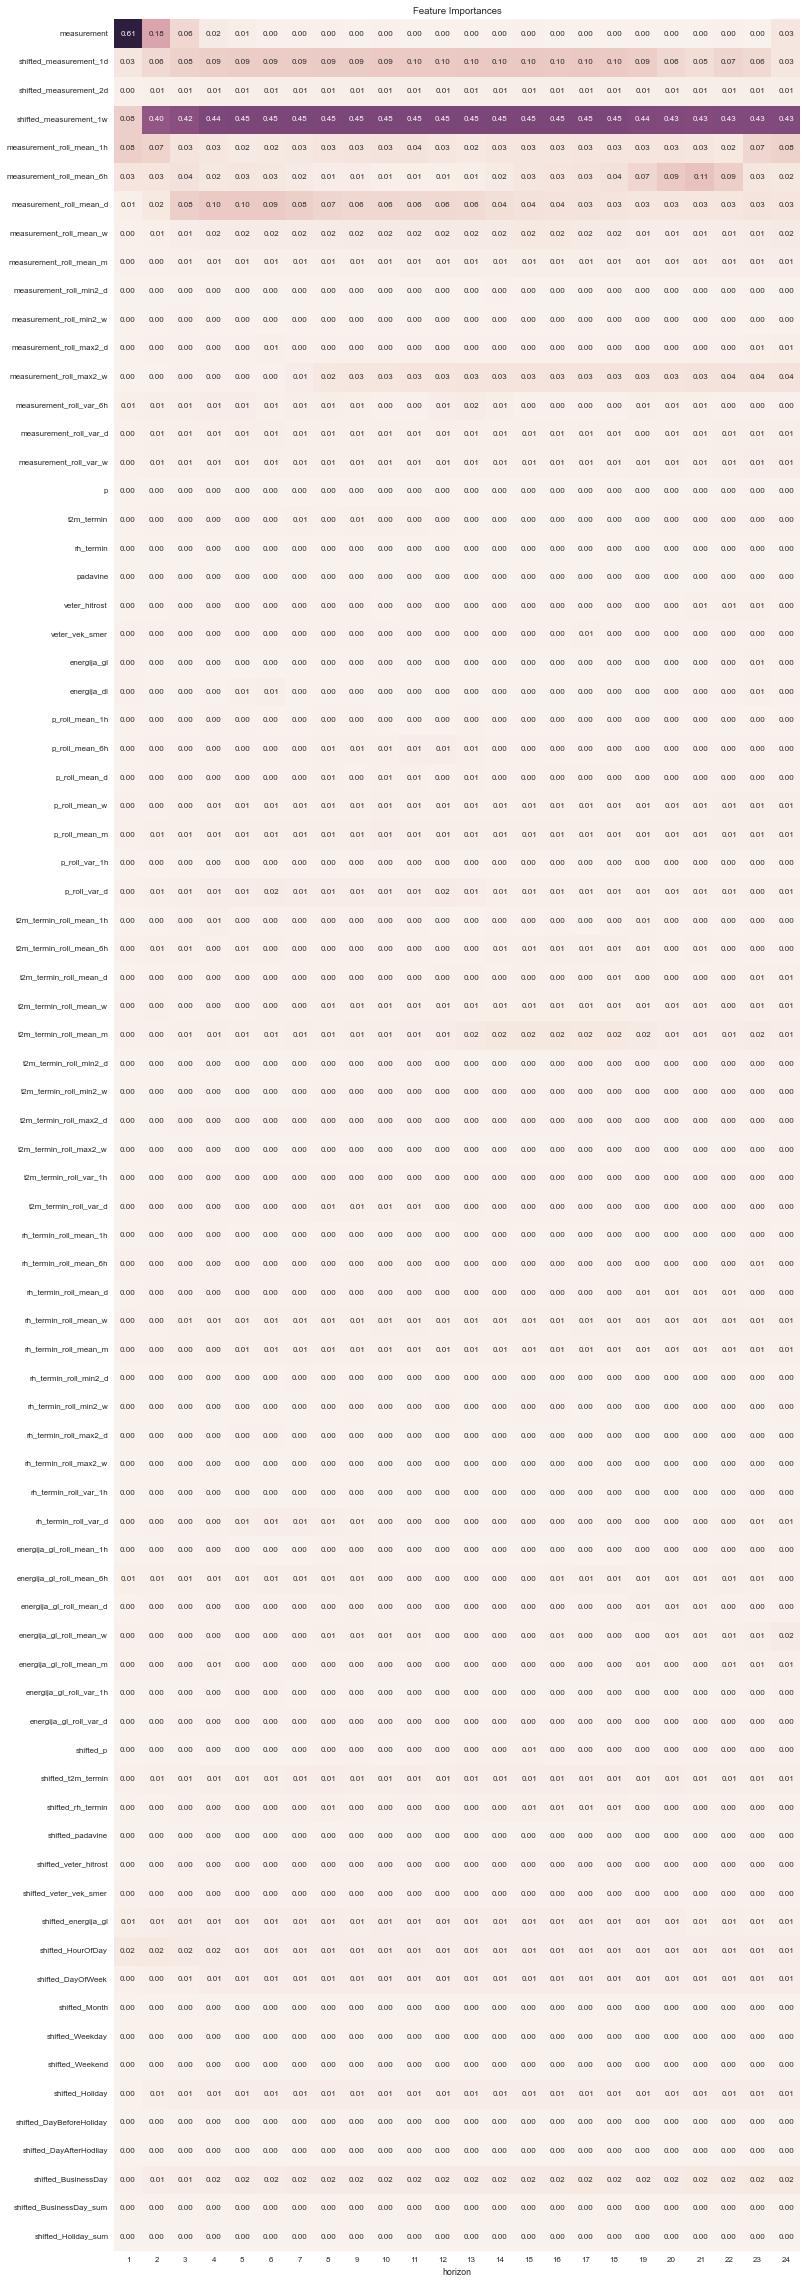

In [13]:
#import seaborn as sns
sns.set(context="paper", font="monospace")
sns.set_style("white")

f, ax = plt.subplots(figsize=(30, 40))
sns.heatmap(feature_importances_all, square=True, annot=True, annot_kws={"size": 8}, fmt=".2f", cbar=False)
plt.title("Feature Importances")
plt.savefig("./figures/featureImportanceAll.pdf")
plt.savefig("./figures/featureImportanceAll.png", dpi=300)

## Top 20 Features of All Time

In [14]:
feature_importances_all_mean = feature_importances_all.mean(axis=1)
feature_importances_all_mean.sort(ascending=False, inplace=True)
feature_importances_all_mean[:20]

shifted_measurement_1w      0.425377
shifted_measurement_1d      0.079981
measurement_roll_mean_d     0.050115
measurement                 0.039630
measurement_roll_mean_1h    0.035302
measurement_roll_mean_6h    0.033153
measurement_roll_max2_w     0.023567
shifted_BusinessDay         0.017166
measurement_roll_mean_w     0.015097
shifted_HourOfDay           0.013252
t2m_termin_roll_mean_m      0.012516
shifted_Holiday             0.011641
shifted_energija_gl         0.010874
shifted_DayOfWeek           0.010318
shifted_t2m_termin          0.009457
p_roll_var_d                0.008596
shifted_measurement_2d      0.007957
measurement_roll_mean_m     0.007690
p_roll_mean_m               0.007600
rh_termin_roll_mean_w       0.006933
dtype: float64

Replace index names

In [15]:
top20_indices = np.argsort(list(feature_importances_all.mean(axis=1)))[::-1][0:20]
top20 = feature_importances_all.ix[top20_indices]
#top20

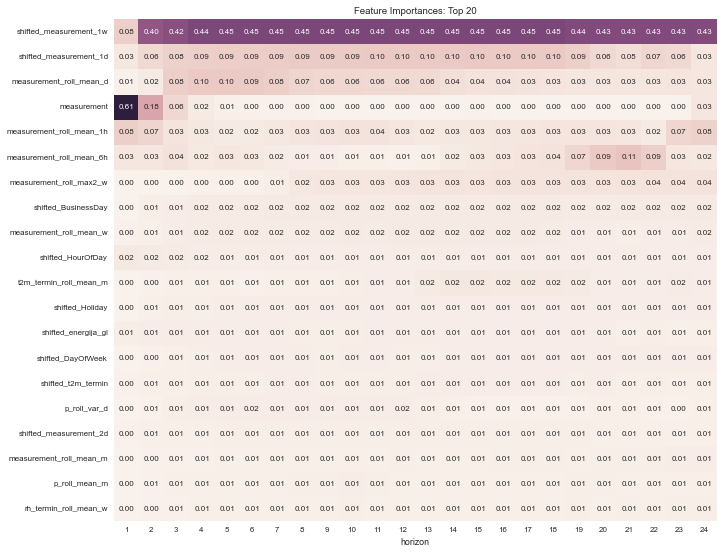

In [16]:
#top20_indices = np.argsort(list(feature_importances_all.mean(axis=1)))[::-1][0:20]

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(top20, square=True, annot=True, annot_kws={"size": 8}, fmt=".2f", cbar=False)
plt.title("Feature Importances: Top 20")
plt.tight_layout()
plt.savefig("./figures/featureImportanceTop20.pdf")
plt.savefig("./figures/featureImportanceTop20.png", dpi=300)

In [23]:
top20_indices = np.argsort(list(feature_importances_all.mean(axis=1)))[::-1][0:20]
top20 = feature_importances_all.ix[top20_indices]

new_index_names = ["measurement_1w_back", "measurement_1d_back", "measurement_MA_d", "measurement", "measurement_MA_h",
                   "measurement_MA_6h", "measurement_MAX_w", "business_day", "measurement_MA_w", "hour_of_day",
                   "temperature_MA_m", "holiday", "forecasted_global_radiation", "day_of_week", "forecasted_temperature",
                   "preassure_VAR_d", "measurement_2d_back", "measurement_MA_m", "preassure_MA_m", "relative_humidity_MA_w"]

top20.index=new_index_names
top20

horizon,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
measurement_1w_back,0.083884,0.396689,0.419818,0.443881,0.445707,0.446498,0.447161,0.447249,0.447320,0.446988,...,0.447301,0.447606,0.447020,0.447291,0.436182,0.434014,0.432529,0.434504,0.434440,0.433886
measurement_1d_back,0.026476,0.061081,0.076868,0.085147,0.087946,0.088310,0.089914,0.091967,0.092278,0.092898,...,0.098006,0.097015,0.097646,0.095507,0.085684,0.061714,0.048305,0.066870,0.060982,0.027680
measurement_MA_d,0.005548,0.019698,0.082634,0.095823,0.095722,0.092793,0.083523,0.068029,0.063016,0.062827,...,0.038441,0.036895,0.033354,0.031386,0.028197,0.027340,0.028078,0.028126,0.031200,0.029147
measurement,0.606680,0.184148,0.063959,0.018727,0.007431,0.004422,0.003464,0.003648,0.002131,0.002749,...,0.004381,0.001383,0.001166,0.001198,0.001383,0.002003,0.002109,0.002408,0.002269,0.027257
measurement_MA_h,0.084864,0.068960,0.032386,0.026575,0.017745,0.019000,0.025674,0.030823,0.031880,0.034622,...,0.026934,0.027868,0.029108,0.029556,0.030834,0.030398,0.027322,0.019684,0.066064,0.077224
measurement_MA_6h,0.029034,0.028670,0.039725,0.021815,0.027316,0.025937,0.017357,0.013096,0.010777,0.006885,...,0.026450,0.029101,0.032741,0.038275,0.065795,0.094549,0.111777,0.085010,0.027825,0.024529
measurement_MAX_w,0.000987,0.001615,0.002813,0.003464,0.003573,0.003407,0.010264,0.024290,0.028335,0.027868,...,0.031351,0.032353,0.032203,0.032030,0.032339,0.032328,0.033373,0.035745,0.036777,0.036073
business_day,0.002449,0.010312,0.014929,0.015745,0.016779,0.016483,0.017595,0.018290,0.018929,0.018845,...,0.018757,0.018897,0.019015,0.018514,0.016915,0.017354,0.019720,0.018875,0.019171,0.019092
measurement_MA_w,0.004193,0.006218,0.011336,0.015510,0.015687,0.015573,0.016244,0.015183,0.016939,0.017734,...,0.019820,0.019637,0.018609,0.017346,0.011687,0.012160,0.010212,0.013933,0.014674,0.017280
hour_of_day,0.020292,0.019208,0.017248,0.015095,0.013266,0.012221,0.011712,0.011394,0.011403,0.012762,...,0.012589,0.011880,0.010984,0.011392,0.011308,0.011150,0.011534,0.011838,0.011505,0.013727


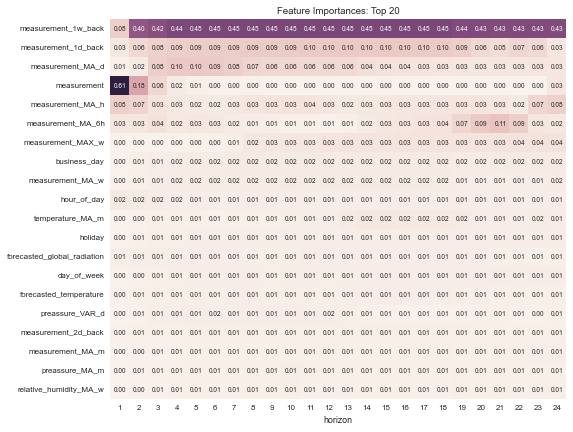

In [24]:
#top20_indices = np.argsort(list(feature_importances_all.mean(axis=1)))[::-1][0:20]

f, ax = plt.subplots(figsize=(8, 6.5))
sns.heatmap(top20, square=True, annot=True, annot_kws={"size": 6.5}, fmt=".2f", cbar=False)
plt.title("Feature Importances: Top 20")
plt.tight_layout()
plt.savefig("./figures/featureImportanceTop20.pdf")
plt.savefig("./figures/featureImportanceTop20.png", dpi=300)

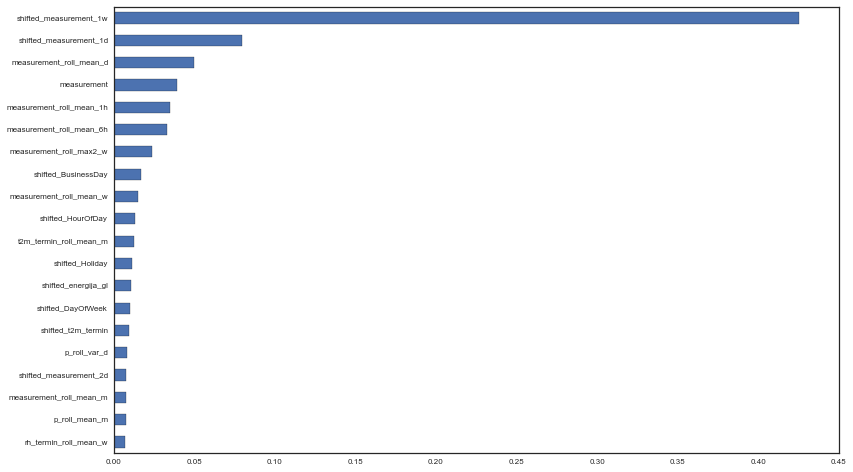

In [19]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

ax = feature_importances_all_mean[:20][::-1].plot(kind='barh', figsize=(13,8))
sns.set_style("whitegrid")
    
plt.savefig("./figures/listOfTop20Features.png", dpi=300)

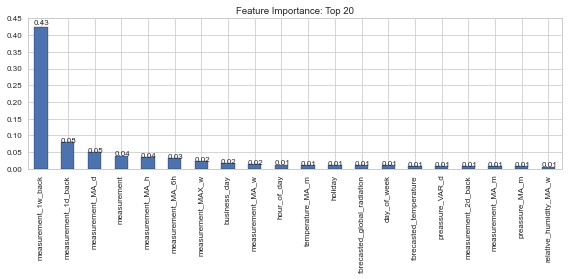

In [25]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

#ax = feature_importances_all_mean[:20].plot(kind='bar', figsize=(12,5), title="Feature Importance: Top 20")
ax = top20.mean(axis=1).plot(kind='bar', figsize=(8,4), title="Feature Importance: Top 20")
sns.set_style("whitegrid")
for p in ax.patches:
    ax.annotate(str("%.2f" % p.get_height()), (p.get_x() , p.get_height() * 1.02), fontsize=8)
plt.tight_layout()
plt.savefig("./figures/listOfTop20Features.png", dpi=300)